In [1]:
import numpy as np
import torch
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer

In [3]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data=True

In [4]:
conf.columns, conf.column_encoder = utils.read_columns()
all_x, all_y, _ = utils.read_dataset("./data/train_curated", conf, lambda s: s)
all_rooms_meta, all_rooms = utils.read_filters("./filters/", conf, lambda s: s)
np.random.seed(42)
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.1)
test_x = list(map(lambda s: utils.trim_and_mel(conf, s), test_x))
train_dataset = trainer.SoundAugDataset(train_x, train_y, 
                                        transform = lambda s: utils.audio_to_melspectrogram(conf, s),
                                        room_filters=all_rooms[:3], 
                                        params={
                                                    "max_size":10000,
                                                    "max_n_mixed":2,
#                                                     "change_pitch":0.1,
#                                                     "change_pitch_max":1,
                                                    "add_echo":0.5,
#                                                     "harmonic_percussive":0.1,
#                                                     "noise_magnitude":0.00005
                                               },
                                        config=conf,
                                        seed=42)
test_dataset = trainer.SoundDataset(test_x, test_y)
aug_coll = trainer.AugmentationCollator(conf, None)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=aug_coll, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

100%|██████████| 73/73 [00:05<00:00, 11.92it/s]


In [8]:
device = torch.device("cuda")
model = models.Net(128, test_x[0].shape[-1], 80)
model = model.to(device)

In [10]:
def optimizer_factory(params):
    result = torch.optim.Adam(params, lr=1e-3)
    return result
    
def scheduler_factory(optimizer):
    result = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
    return result

In [11]:
tr = trainer.Trainer(model, optimizer_factory, scheduler_factory, device, {"path":"./experiments/paper/"})

Saving the weights and metrics to  ./experiments/paper/2019-06-17.09.48.48


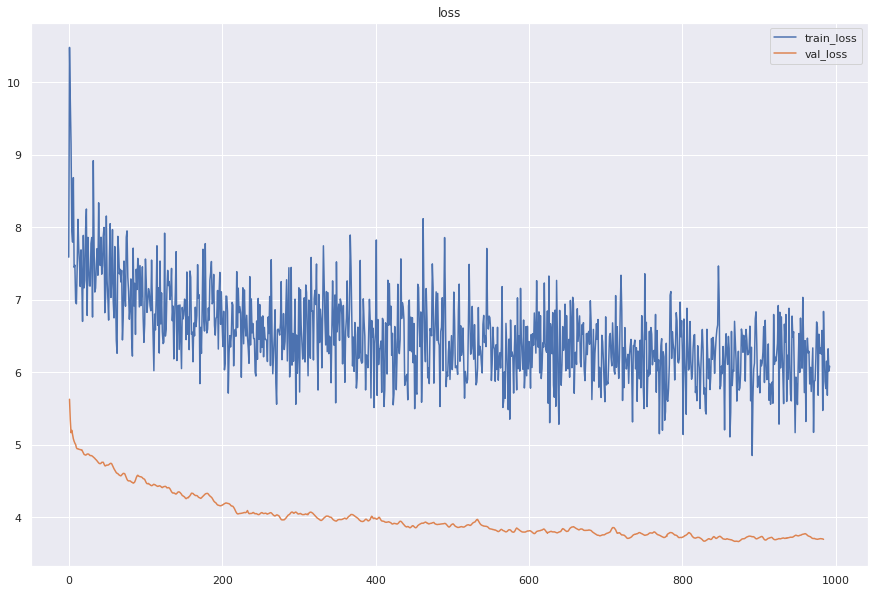

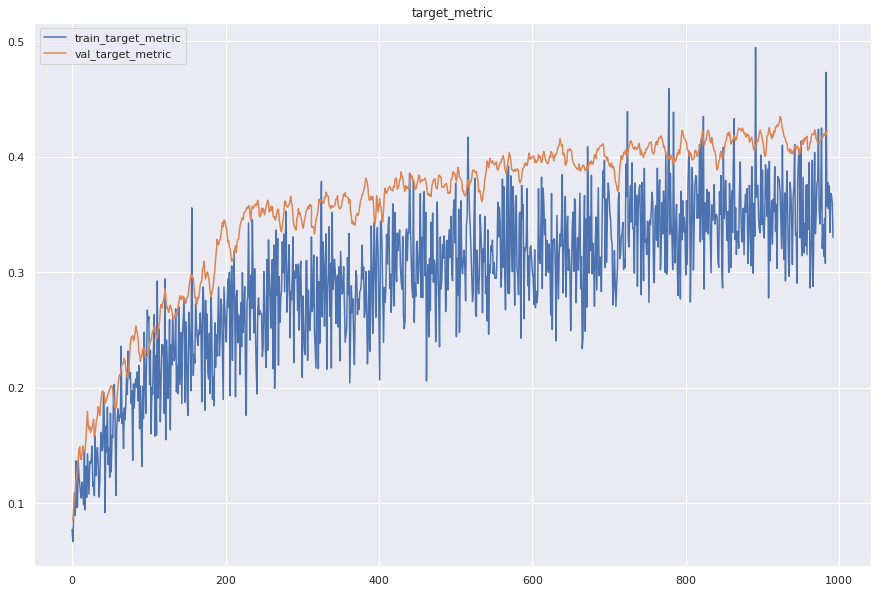

In [ ]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":250, "grad_clip_norm":10.0, "validate_every":25},
)